<a href="https://colab.research.google.com/github/zxcej/COMP691_LABS/blob/main/Johnson_2023_Lab3_Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 3 Exercises for COMP 691 (Deep Learning)

In this lab we will go over over basic stochastic optimization and how to use it in PyTorch.
- You will use the neural network you setup in lab 2 Exercise 2.
- Learn about parameter initialization.
- Learn about cross entropy loss.
- Train the neural network using mini-batch SGD w/o momentum. 

Start by making a **copy** of this notebook in your Google Colab.


A good source for understanding leaf tensors is [here](https://stackoverflow.com/questions/65301875/how-to-understand-creating-leaf-tensors-in-pytorch).

## Exercise 1: Loading the dataset

Setup the MNIST dataloaders for both the training (as well test) set as in Lab 2, Exercise 1. You do not need to iterate through the dataloaders, these will be used in the rest of the lab. 


In [1]:
# This cell does not require outputing anything but is setup for subsequent cells
import torch
from torch import nn
from torchvision import transforms,datasets
from torch.utils import data
from torch.nn import functional as F
from matplotlib import pyplot as plt
import math


transform=transforms.Compose([
        transforms.ToTensor()
        ])

train_batch_size = 256
test_batch_size = 256

# load MNIST train and test sets
mnist_train = datasets.MNIST(root='.',
                             train=True,
                             download=True,
                              transform=transform)
mnist_test = datasets.MNIST(root='.',
                            train=False,
                            download=True,
                            transform=transform)

# initialize dataloaders for MNIST train and test sets
train_dataloader = data.DataLoader(mnist_train,batch_size=train_batch_size,drop_last=True)
test_dataloader = data.DataLoader(mnist_test,batch_size=test_batch_size,drop_last=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Exercise 2: Setting up the neural network

Consider your work from Lab 2, Exercise 2. Modify the neural network as follows. 
- The hidden outputs should have size 100 in both hidden layers and the activations should be `relu`. 
- Modify the final layer to output 10 values instead of 1. This means that instead of having a single scalar value, you will have 10 output classes!

Your code should implement 

$$f(x) = W_2\rho(W_1\rho(W_0x+b_0)+b_1)+b_2$$

with $f: R^{786}-> R^{10}$ and $\rho = $ `relu`

**Initialize** the weights  using a variant of xavier intialization 

$$w_{ij} \sim \text{N}\left(0,\frac{1}{\sqrt{n_i}}\right)$$

where $n_i$ is the size of the layer input. Initialize the biases as 0. 

**Write** a helper function to perform this initialization for subsequent parts of this lab.

In [2]:
import torch

# set your target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Initialize and track the parameters using a list or dictionary
h1_size = 50
h2_size = 50
param_dict = {
    "W0": torch.rand(784, h1_size)*2-1,
    "b0": torch.rand(h1_size)*2-1, 
    "W1": torch.rand(h1_size, h2_size)*2-1,
    "b1": torch.rand(h2_size)*2-1,
    "W2": torch.rand(h2_size,10)*2-1,
    "b2": torch.rand(10)*2-1,
    }

## Make sure your parameters in param_dict are on the chosen device and that they require gradient for training the network later! 
for name, param in param_dict.items():
    param_dict[name] = param.to(device)
    param.requires_grad=True

## Define the network
def my_nn(input, param_dict):
    """Performs a single forward pass of a Neural Network with the given 
    parameters in param_dict.

    Args:
        input (torch.tensor): Batch of images of shape (B, H, W), where B is 
            the number of input samples,and H and W are the image height and 
            width respectively.
        param_dict (dict of torch.tensor): Dictionary containing the parameters
            of the neural network. Expects dictionary keys to be of format 
            "W#" and "b#" where # is the layer number.

    Returns:
        torch.tensor: Neural network output of shape (B, )
    """
    x = input.view(-1 , 28*28) 

    # layer 1
    x = torch.relu_(x @ param_dict['W0'] + param_dict['b0'])

    # layer 2
    x = torch.relu_(x @ param_dict['W1'] + param_dict['b1'])

    # output 
    x = x @ param_dict['W2']  + param_dict['b2']

    return x


def initialize_nn(param_dict):
  """Takes a dictionary with existing torch tensors 
      and re-initializes them using xavier initialization
  """

  # make sure that your parameters are on the chosen device and that they require gradients!
  for name, param in param_dict.items():
        param_dict[name] = torch.zeros_like(param)
        if "W" in name:
            param_dict[name] = param_dict[name].normal_(0,1/math.sqrt(param.size(0)))
        # turn on parameter gradients for parameters, and move them to device
        param_dict[name] = param_dict[name].to(device)
        param_dict[name].requires_grad = True

initialize_nn(param_dict)

Now, we will evaluate the cross entropy loss and average accuracy on this randomly initialized dataset. 

Use the `torch.nn.functional.cross_entropy()` function to compute the loss $\frac{1}{N}\sum_i^N \text{CrossEntropy}(f(x_i),y_i)$ and accuracy.

Your accuracy should be close to $10\%$ as the network has random weights and no training has happened yet!

In [3]:
cuda = torch.cuda.is_available()
def test(test_dataloader):
    loss = 0
    accuracy = 0

    for data, targets in test_dataloader:
      #move to GPU if available
      if cuda:
          data, targets = data.to('cuda'), targets.to('cuda')

      #compute model output
      output = my_nn(data,param_dict)
      #comptue accuracy for minibatch
      prediction = output.argmax(1)
      accuracy += sum(prediction == targets).item()/test_batch_size
      #compute loss for minibatch
      loss += F.cross_entropy(output,targets).item()
#aggregate loss and accuracy for all test data
    print(f'test loss: {loss/len(test_dataloader):4f}')
    print(f'test accuracy: {accuracy/len(test_dataloader)*100:.2f}%')

test(test_dataloader)

  

test loss: 2.335638
test accuracy: 7.28%


## Exercise 3: Training using mini-batch SGD from scratch

Without using the `torch.optim` package implement from scratch mini-batch Stochastic Gradient Descent training to minimize the loss  $\frac{1}{N}\sum_i^N \text{CrossEntropy}(f(x_i),y_i)$ over the MNIST dataset. 

- Use a minibatch size of 128 and a learning rate of 0.01. Run the training for 20 epochs.

- You will PyTorch's autograd features (e.g. `.backward()`) to obtain the gradients given each mini-batch at each parameter. Modify the existing parameters based on the obtained gradient using the SGD update rule, e.g. $w = w - \alpha * \frac{\partial loss}{\partial w}$.

- Store the losses and training of each minibatch and plot each of these (with iterations (not epochs) as the $x$-axis). You can optionally smooth out these plots over 20-100 iteration window of your choosing to make them cleaner to read. 

- Compute and report the final test accuracy as well at the end of the 20 epochs. 


You should end up with 2 plots and a final test accuracy that looks something like this

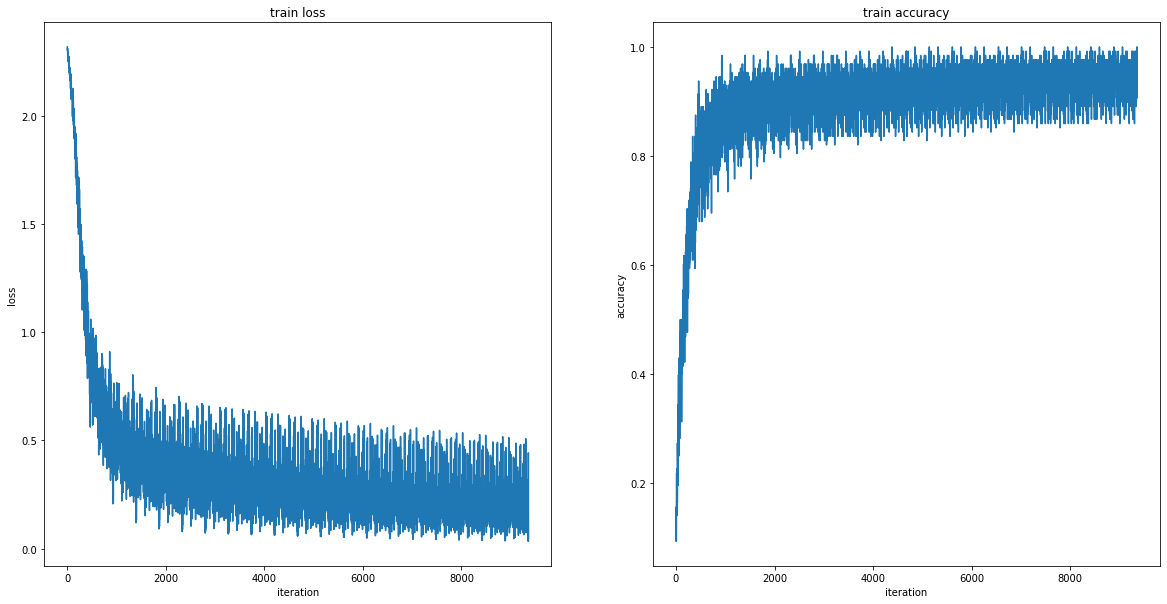


 epoch 0: train loss 1.6272- train accuracy 56.56%
 epoch 1: train loss 1.1262- train accuracy 70.54%
 epoch 2: train loss 0.8972- train accuracy 76.38%
 epoch 3: train loss 0.7676- train accuracy 79.62%
 epoch 4: train loss 0.6835- train accuracy 81.74%
 epoch 5: train loss 0.6240- train accuracy 83.23%
 epoch 6: train loss 0.5792- train accuracy 84.36%
 epoch 7: train loss 0.5441- train accuracy 85.25%
 epoch 8: train loss 0.5155- train accuracy 85.98%
 epoch 9: train loss 0.4917- train accuracy 86.58%
 epoch 10: train loss 0.4714- train accuracy 87.10%
 epoch 11: train loss 0.4538- train accuracy 87.54%
 epoch 12: train loss 0.4383- train accuracy 87.94%
 epoch 13: train loss 0.4246- train accuracy 88.30%
 epoch 14: train loss 0.4122- train accuracy 88.62%
 epoch 15: train loss 0.4009- train accuracy 88.92%
 epoch 16: train loss 0.3906- train accuracy 89.19%
 epoch 17: train loss 0.3812- train accuracy 89.44%
 epoch 18: train loss 0.3724- train accuracy 89.67%
 epoch 19: train loss 

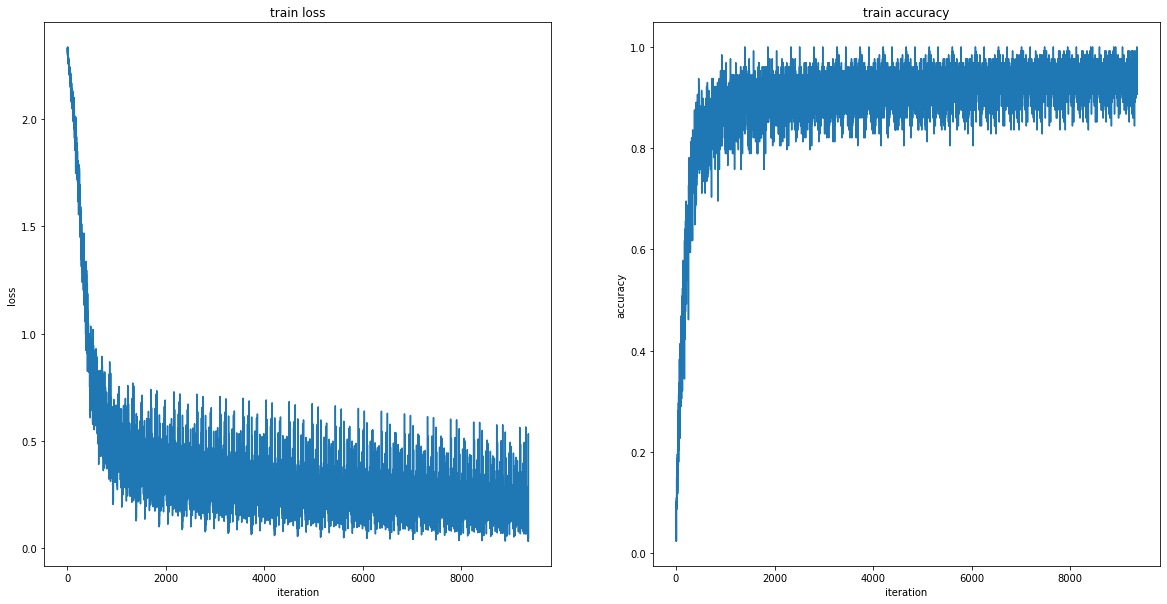

In [4]:
import torch
from torch.utils import data

initialize_nn(param_dict)

train_batch_size=128
lr = 0.01

train_dataloader = data.DataLoader(mnist_train,batch_size=train_batch_size,drop_last=True)

train_losses = [] # use to append the avg loss for each minibatch 
train_accs = [] # use to append the avg acc of minibatch

alpha=0.01


for epoch in range(20):
    for data,target in train_dataloader: #Iterate over dataset
    #Compute the gradient for the minibatch
      data, target = data.to(device), target.to(device)
      #compute model output
      output = my_nn(data,param_dict)
      #compute the gradient for the minibatch
      loss = F.cross_entropy(output,target)
      loss.backward()
      # track training loss and accuracy
      train_losses.append(loss.item())
      prediction = output.argmax(1)
      train_accs.append(sum(prediction == target).item()/train_batch_size)
    
      for (name ,param) in param_dict.items():
          with torch.no_grad():
            param_dict[name] -= alpha * param_dict[name].grad
          #Update the model parameters by w_t-alpha*grad
          if param.grad is not None: 
          #The following code will clear the gradient buffers for the next iteration
            param.grad.detach_() 
            param.grad.zero_()
    print(f' epoch {epoch}: train loss {sum(train_losses)/(len(train_dataloader)*(epoch+1)):.4f}- train accuracy {sum(train_accs)/(len(train_dataloader)*(epoch+1))*100:.2f}%')
    
    #Update loss and acc tracking 
train_loss_sgd = train_losses
train_accs_sgd = train_accs
#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_losses)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].plot(train_accs)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')

#Evaluate on the test set
test(test_dataloader)



## Exercise 4: Training using the pre-built torch.optim.SGD

Repeat Exercise 3 but now using the package `torch.optim.SGD` to perform SGD: 


https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20sgd#torch.optim.SGD


Plot the same training curves and accuracy curves. Check that your learning curves are similar to those in Exercise 3. You can for example overlay them or plot them side by side with subplot.

 epoch 0: train loss 1.5671- train accuracy 58.35%
 epoch 1: train loss 1.0883- train accuracy 71.62%
 epoch 2: train loss 0.8730- train accuracy 77.06%
 epoch 3: train loss 0.7506- train accuracy 80.12%
 epoch 4: train loss 0.6707- train accuracy 82.12%
 epoch 5: train loss 0.6137- train accuracy 83.54%
 epoch 6: train loss 0.5706- train accuracy 84.63%
 epoch 7: train loss 0.5364- train accuracy 85.49%
 epoch 8: train loss 0.5086- train accuracy 86.20%
 epoch 9: train loss 0.4852- train accuracy 86.81%
 epoch 10: train loss 0.4652- train accuracy 87.32%
 epoch 11: train loss 0.4479- train accuracy 87.77%
 epoch 12: train loss 0.4326- train accuracy 88.16%
 epoch 13: train loss 0.4189- train accuracy 88.52%
 epoch 14: train loss 0.4066- train accuracy 88.84%
 epoch 15: train loss 0.3954- train accuracy 89.14%
 epoch 16: train loss 0.3851- train accuracy 89.41%
 epoch 17: train loss 0.3757- train accuracy 89.66%
 epoch 18: train loss 0.3669- train accuracy 89.89%
 epoch 19: train loss 

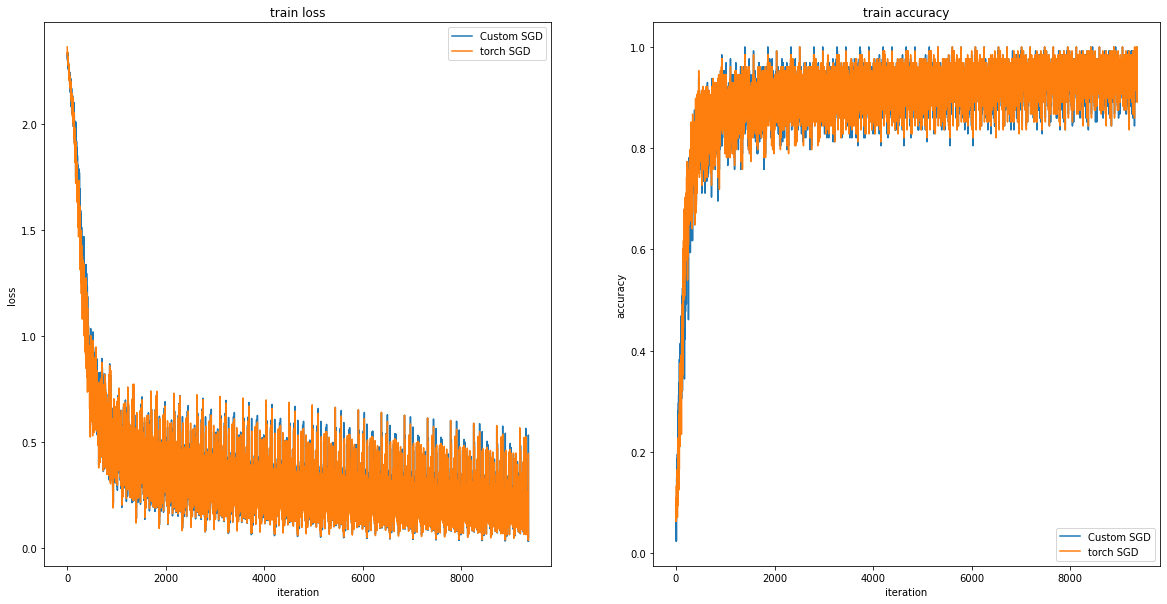

In [5]:
#Answer for SGD
import torch
#Make sure to reinitialize your network to random before starting training
initialize_nn(param_dict)

#optim.SGD takes a list of parameters which you can get from your dictionary as follows
parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=alpha)

def train_SGD(train_dataloader,optimizer):
  train_loss = []
  train_accuracy = []
  for epochs in range (20):
    for data,targets in train_dataloader:
      data,targets = data.to(device),targets.to(device)
       # set gradients to zero
      optimizer.zero_grad()
      output = my_nn(data,param_dict)
      loss = F.cross_entropy(output,targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      prediction = output.argmax(1)
      train_accuracy.append(sum(prediction == targets).item()/train_batch_size)
    print(f' epoch {epochs}: train loss {sum(train_loss)/(len(train_dataloader)*(epochs+1)):.4f}- train accuracy {sum(train_accuracy)/(len(train_dataloader)*(epochs+1))*100:.2f}%')
  return train_loss,train_accuracy

train_loss,train_accuracy = train_SGD(train_dataloader,optimizer)

#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_loss_sgd,label='Custom SGD')
axs[0].plot(train_loss,label='torch SGD')
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accs_sgd,label='Custom SGD')
axs[1].plot(train_accuracy,label='torch SGD')
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
axs[1].legend()
#Evaluate on the test set
test(test_dataloader)





## Optional: Training using mini-batch SGD with momentum

Modify the code from Exercises 3 and 4 to perform minibatch SGD with momentum. Use a momentum of $\mu=0.9$ and learning rate $\alpha=0.01$. Use the following formulation of momentum: 

- $g = \nabla_wCE(f(w_t,X),Y)$: gradient estimate with mini-batch
- $v_{t+1} = \mu * v_t + g$ 
- $w_{t+1} = w - \alpha*v_{t+1}$ 

Obtain the same plots as before and a final test accuracy.

 epoch 0: train loss 0.5799- train accuracy 83.54%
 epoch 1: train loss 0.4161- train accuracy 88.09%
 epoch 2: train loss 0.3431- train accuracy 90.12%
 epoch 3: train loss 0.2981- train accuracy 91.39%
 epoch 4: train loss 0.2665- train accuracy 92.28%
 epoch 5: train loss 0.2426- train accuracy 92.95%
 epoch 6: train loss 0.2237- train accuracy 93.48%
 epoch 7: train loss 0.2082- train accuracy 93.93%
 epoch 8: train loss 0.1951- train accuracy 94.30%
 epoch 9: train loss 0.1838- train accuracy 94.62%
 epoch 10: train loss 0.1740- train accuracy 94.90%
 epoch 11: train loss 0.1654- train accuracy 95.15%
 epoch 12: train loss 0.1577- train accuracy 95.37%
 epoch 13: train loss 0.1507- train accuracy 95.57%
 epoch 14: train loss 0.1445- train accuracy 95.75%
 epoch 15: train loss 0.1387- train accuracy 95.92%
 epoch 16: train loss 0.1334- train accuracy 96.08%
 epoch 17: train loss 0.1286- train accuracy 96.23%
 epoch 18: train loss 0.1241- train accuracy 96.36%
 epoch 19: train loss 

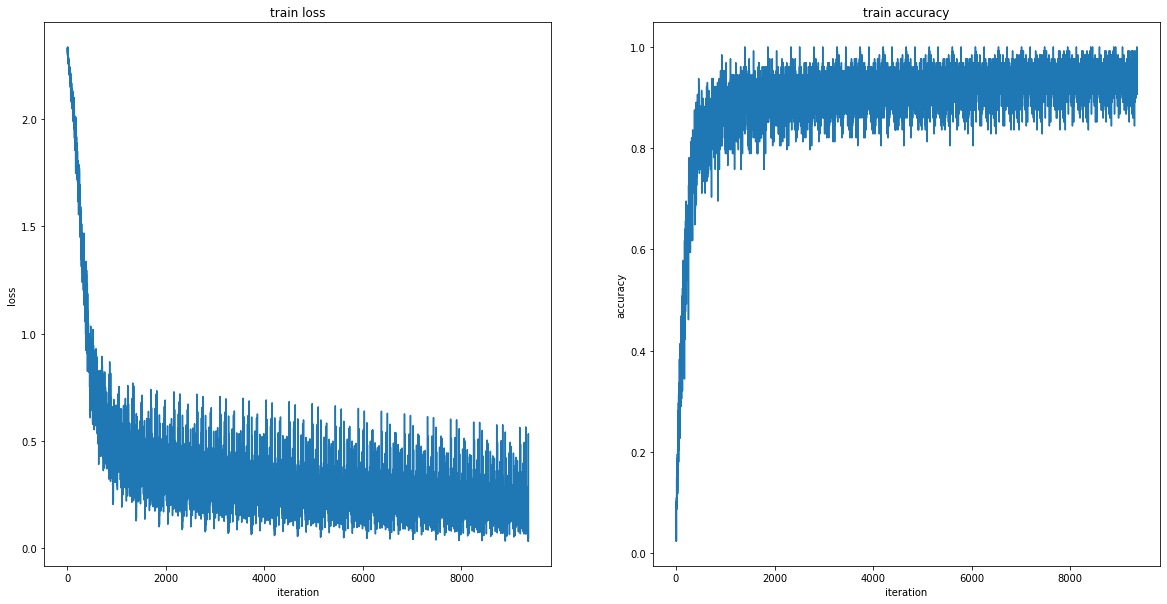

In [7]:
# Reinitialize your network to random!
initialize_nn(param_dict)

losses = [] # use to append the avg loss for each minibatch 
train_acc = [] # use to append the avg acc of minibatch

alpha=0.01
mu=0.9

#velocity
v={}
for (name,param) in param_dict.items():
    v[name] = torch.zeros_like(param)

for epoch in range(20):
    for data,target in train_dataloader: #Iterate over dataset
    #Compute the gradient for the minibatch
        data, target = data.to(device), target.to(device)
        #compute model output
        output = my_nn(data,param_dict)
        #compute the gradient for the minibatch
        loss = F.cross_entropy(output,target)
        loss.backward()
        # track training loss and accuracy
        losses.append(loss.item())
        prediction = output.argmax(1)
        train_acc.append(sum(prediction == target).item()/train_batch_size)
      
        for (name ,param) in param_dict.items():
            with torch.no_grad():
                v[name] = mu*v[name] + param_dict[name].grad 
                param_dict[name] -= alpha * v[name]
            #Update the model parameters by w_t-alpha*grad
            if param.grad is not None: 
            #The following code will clear the gradient buffers for the next iteration
              param.grad.detach_() 
              param.grad.zero_()

      #Update loss and acc tracking 
    print(f' epoch {epoch}: train loss {sum(losses)/(len(train_dataloader)*(epoch+1)):.4f}- train accuracy {sum(train_acc)/(len(train_dataloader)*(epoch+1))*100:.2f}%')

train_loss_mom = losses
train_accs_mom = train_acc
#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_losses)
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[1].plot(train_accs)
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
#Evaluate on the test set
test(test_dataloader)


 epoch 0: train loss 0.5599- train accuracy 83.71%
 epoch 1: train loss 0.4065- train accuracy 88.15%
 epoch 2: train loss 0.3371- train accuracy 90.16%
 epoch 3: train loss 0.2940- train accuracy 91.41%
 epoch 4: train loss 0.2635- train accuracy 92.30%
 epoch 5: train loss 0.2403- train accuracy 92.98%
 epoch 6: train loss 0.2219- train accuracy 93.52%
 epoch 7: train loss 0.2067- train accuracy 93.96%
 epoch 8: train loss 0.1938- train accuracy 94.33%
 epoch 9: train loss 0.1828- train accuracy 94.65%
 epoch 10: train loss 0.1733- train accuracy 94.93%
 epoch 11: train loss 0.1648- train accuracy 95.17%
 epoch 12: train loss 0.1573- train accuracy 95.39%
 epoch 13: train loss 0.1505- train accuracy 95.59%
 epoch 14: train loss 0.1444- train accuracy 95.77%
 epoch 15: train loss 0.1388- train accuracy 95.94%
 epoch 16: train loss 0.1336- train accuracy 96.09%
 epoch 17: train loss 0.1289- train accuracy 96.23%
 epoch 18: train loss 0.1245- train accuracy 96.36%
 epoch 19: train loss 

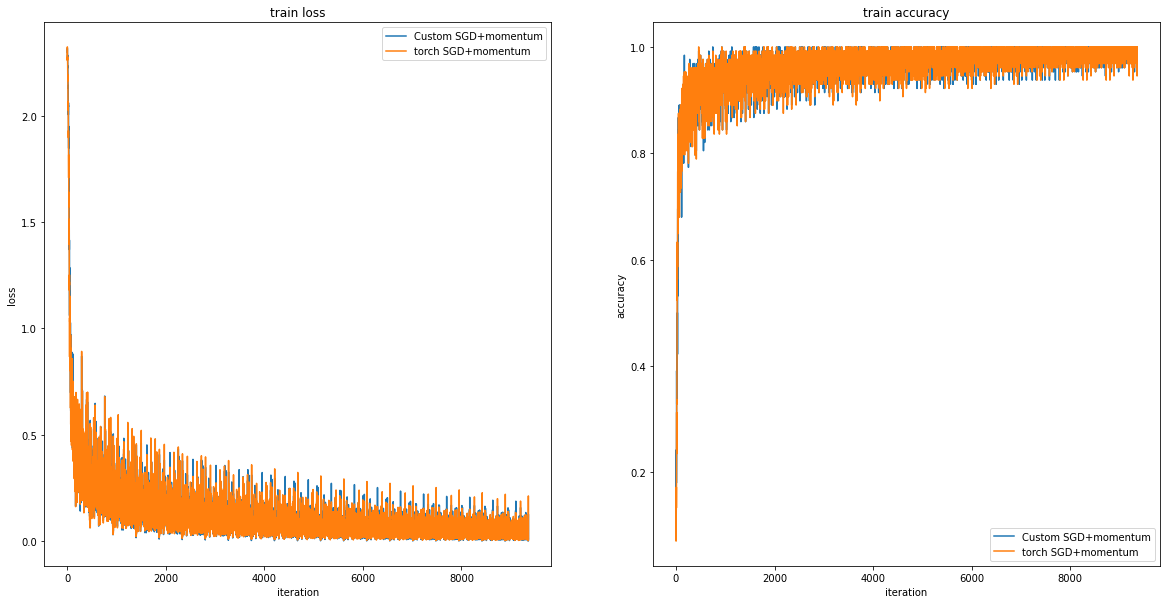

In [8]:
# Answer for SGD+momentum
#Make sure to reinitialize your network to random before starting training
initialize_nn(param_dict)

#optim.SGD takes a list of parameters which you can get from your dictionary as follows
parameter_list = param_dict.values()

optimizer = torch.optim.SGD(parameter_list, lr=alpha, momentum=mu)

train_losses , train_accs = train_SGD(train_dataloader,optimizer)

#Plot the train loss and acc
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(train_loss_mom,label='Custom SGD+momentum')
axs[0].plot(train_losses,label='torch SGD+momentum')
axs[0].set_title('train loss')
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accs_mom,label='Custom SGD+momentum')
axs[1].plot(train_accs,label='torch SGD+momentum')
axs[1].set_title('train accuracy')
axs[1].set_xlabel('iteration')
axs[1].set_ylabel('accuracy')
axs[1].legend()
#Evaluate on the test set
test(test_dataloader)
     